In [1]:
# 패키지 임포트
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### DB에서 데이터를 불러와 json으로 저장하는 함수

In [2]:
def DB_connect(date,lat,lon):
    # DB 연결
    connection = psycopg2.connect(host="203.253.202.21", dbname="marine_env", user="postgres", password="kkilab3415", port=5432)
    cur = connection.cursor()
    
    offset_num = 0
    data = []
    
#     cur.execute("SELECT DISTINCT datetime FROM public.wave_current2018 ORDER BY datetime ASC") 
#     date_unique = cur.fetchall()
    # 출력할 위도, 경도 범위 설정
#     lon=[126.0, 127.0]
#     lat=[33.0,34.0]

#     while True:
        # 원하는 데이터 출력(데이터 3000개)
    cur.execute(f"SELECT * FROM public.wave_current2018 WHERE (datetime = '{date_unique[0][0]}')") 
    data0 = cur.fetchall()
    data += data0
#         cur.execute(f"SELECT * FROM public.wave_current2018 WHERE (lat BETWEEN {lat[0]} AND {lat[1]}) AND (lon BETWEEN {lon[0]} AND {lon[1]}) AND (datetime = '{date_unique[0][0]}') LIMIT 3000 OFFSET {offset_num}")
#         cur.execute(f"SELECT * FROM public.wave_current2018 WHERE (datetime = '{date_unique[0][0]}') LIMIT 3000 OFFSET {offset_num}")
#         data0 = cur.fetchall()
#         data += data0
#         if len(data0)<3000:
#         #if offset_num>500:
#             break

#         offset_num+=3000

    cur.close() 
    connection.close()
    
    header = ['datetime', 'lat', 'lon', 'elev', 'currentu', 'currentv', 'windu', 'windv', 'apress']
    
    # Json파일 저장
    ## datetime 제외(index0)
    ## elev 제외(index3)
    ## apress 제외(index8)
    sample = {}
    
    with open(f'wave_current_2018_lat{lat[0]}_{lat[1]}_lon{lon[0]}_{lon[1]}.json','w') as tc2018:
        
        # 예외처리(추출한 데이터가 없을 경우 함수를 종료)
        if len(data)==0:
            tc2018.write('{\n"current_data": [\n')
            json.dump(sample, tc2018)
            tc2018.write(']\n}')
        else:  
            tc2018.write('{\n"current_data": [\n')
            for i in range(1,len(data)):
                for j in range(1,len(header)):
                    if j==3 or j==8:
                        continue
                    else:
                        sample[header[j]] = data[i][j]

                json.dump(sample, tc2018)

                if not i == len(data)-1:
                    tc2018.write(',\n')

            tc2018.write(']\n}')
       # data_json=open('wave_current_2018.json','r').read()


#### json 데이터로 특정시점의 그래프를 각 위경도별로 저장하는 함수 

In [14]:
def plot_with_json(json_filename, lat, lon):
    # json데이터 불러오기
    with open(json_filename) as f:
        data = json.load(f)
 
    # 예외처리(추출한 데이터가 없을 경우 함수를 종료)
    if len(data['current_data'])!=0:
        current_data = data['current_data']
        header = ['lat', 'lon', 'currentu', 'currentv', 'windu', 'windv']
        data_pd = pd.DataFrame(current_data, columns=header)

        # 지도데이터 불러오기
        map1 = pd.read_csv('SW_korea_map.csv')

        # 바람세기
        data_pd['wind_force'] = np.sqrt(data_pd['windu']**2 + data_pd['windv']**2)  # 세기

        # 조류세기
        data_pd['current_force'] = np.sqrt(data_pd['currentu']**2 + data_pd['currentv']**2) # 세기

        # 조류 육지 데이터 삭제
        data_pd['current_force'][data_pd['current_force']>100] = np.nan

        data_pd=data_pd.drop_duplicates()
        
        # drop_duplicates과정에서 생성된 쓰레기 데이터를 제거
        #data_pd = data_pd[0:-1]

        # 지도 범위
        latlmt = lat
        lonlmt = lon
        
        x_list = data_pd.lon[(data_pd.lon>lonlmt[0]) & (data_pd.lon<lonlmt[1]) & (data_pd.lat>latlmt[0]) & (data_pd.lat<latlmt[1])].unique()
        y_list = data_pd.lat[(data_pd.lon>lonlmt[0]) & (data_pd.lon<lonlmt[1]) & (data_pd.lat>latlmt[0]) & (data_pd.lat<latlmt[1])].unique()
        
        # 배열 리스트 정렬
        x_list = np.sort(x_list)
        y_list = np.sort(y_list)
        
        X, Y = np.meshgrid(x_list, y_list)

        current_data_pd = np.zeros(X.shape)

        for i in range(x_list.shape[0]):
            for j in range(y_list.shape[0]):
                if len(data_pd.current_force[(data_pd.lon==x_list[i]) & (data_pd.lat == y_list[j])].values):
                    current_data_pd[j,i] = data_pd.current_force[(data_pd.lon==x_list[i]) & (data_pd.lat==y_list[j])].values

        # 시각화
        plt.figure(figsize=(20,20))
        #plt.plot(map1.lon.values,map1.lat.values, 'b.', MarkerSize = 2) # 연안 좌표

        plt.pcolor(X, Y, current_data_pd, vmax=0.5, vmin=0, alpha=0.7)

        # 그래프 설정
        plt.xlim(lonlmt[0],lonlmt[1])
        plt.ylim(latlmt[0],latlmt[1])
        plt.axis('off')

        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())

        # 그래프 저장
        plt.savefig(f'./current_plots/current_force_lat{lat[0]}_{lat[1]}_lon{lon[0]}_{lon[1]}_date{1}.png',dpi=150, bbox_inches='tight', pad_inches=0)

#### 데이터의 날짜목록출력 함수(임시사용, DB개편시 사용 안할 가능성 높음)

In [4]:
def date_list():
    connection = psycopg2.connect(host="203.253.202.21", dbname="marine_env", user="postgres", password="kkilab3415", port=5432)

    cur = connection.cursor()

    cur.execute("SELECT DISTINCT datetime FROM public.wave_current2018 ORDER BY datetime ASC") 
    date_unique = cur.fetchall()
    cur.close() 
    connection.close()
    
    return date_unique

#### 반복문을 이용하여 위경도별 그래프를 저장

In [5]:
# 연월일시간 지정
date_unique = date_list()
date = date_unique[0][0]

In [6]:
# DB내 데이터의 위경도 범위 확인 결과 : [(124.51041666666667, 130.11458333333314, 32.90624999999942, 35.489583333333165)]

# 위경도 초기값
lon0 = 123.0
lat0 = 32.0

# 위경도 변화 간격
dlon = 8
dlat = 4

데이터 추출 중...lat:32.0~36.0, lon:123.0~131.0
그래프 그리는 중...lat:32.0~36.0, lon:123.0~131.0


C:\Users\user\AppData\Local\Temp/ipykernel_7208/2280176116.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, current_data_pd, vmax=0.5, vmin=0, alpha=0.7)


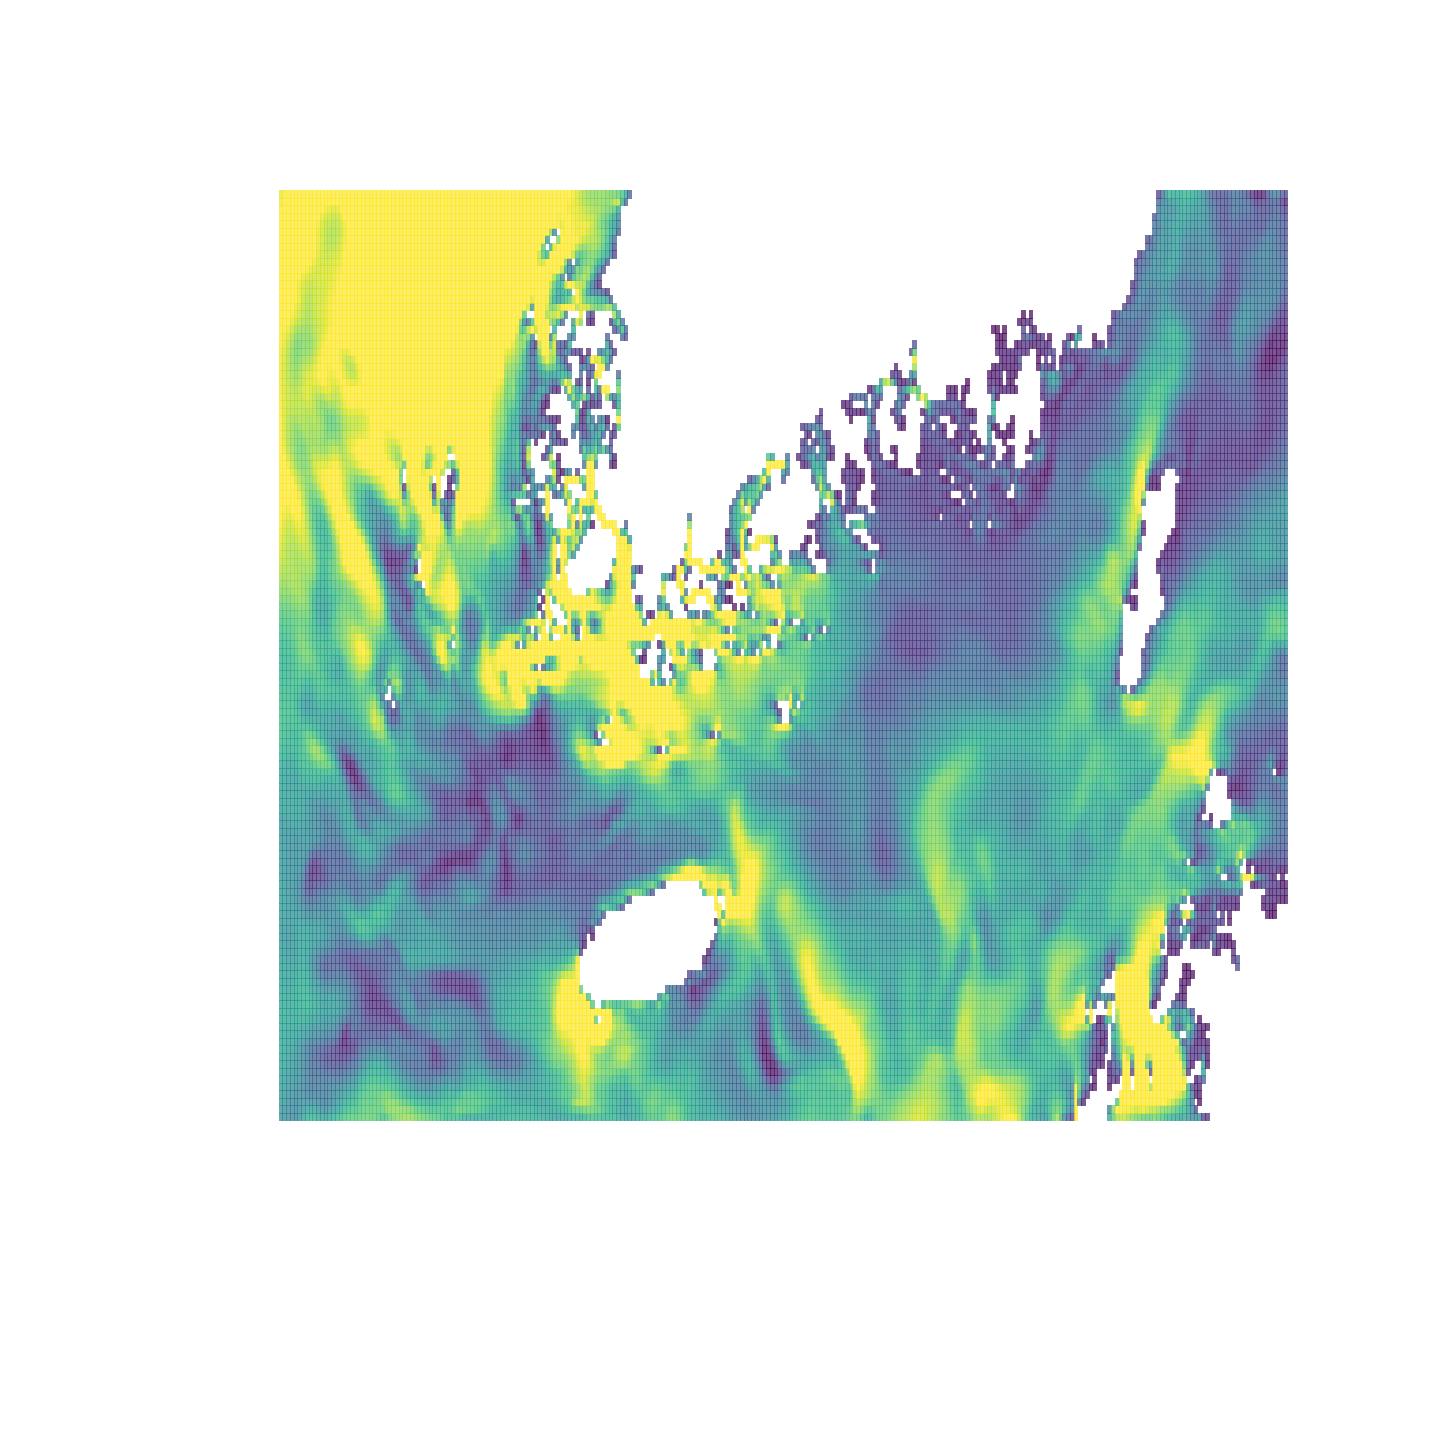

In [15]:
lon1 = lon0
lat1 = lat0

lat=[lat1, lat1+dlat]
lon=[lon1, lon1+dlon]
print(f"데이터 추출 중...lat:{lat[0]}~{lat[1]}, lon:{lon[0]}~{lon[1]}")
DB_connect(date,lat,lon)
print(f"그래프 그리는 중...lat:{lat[0]}~{lat[1]}, lon:{lon[0]}~{lon[1]}")
plot_with_json(f'wave_current_2018_lat{lat[0]}_{lat[1]}_lon{lon[0]}_{lon[1]}.json', lat, lon)

In [8]:
# lon1 = lon0
# lat1 = lat0

# for i in range(0,1):
#     lat=[lat1, lat1+dlat]
#     for j in range(0,1):
#         lon=[lon1, lon1+dlon]
#         print(f"데이터 추출 중...lat:{lat[0]}~{lat[1]}, lon:{lon[0]}~{lon[1]}")
#         DB_connect(date,lat,lon)
#         print(f"그래프 그리는 중...lat:{lat[0]}~{lat[1]}, lon:{lon[0]}~{lon[1]}")
#         plot_with_json(f'wave_current_2018_lat{lat[0]}_{lat[1]}_lon{lon[0]}_{lon[1]}.json', lat, lon)
# #         plot_with_json(f'wave_current_2018_lat{lat[0]}_{lat[1]}_lon{lon[0]}_{lon[1]}.json', lat, lon)
        
#         lon1+=dlon
#     lon1= lon0
#     lat1+=dlat

In [9]:
# with open('wave_current_2018_lat32.0_36.0_lon123.0_131.0.json') as f:
#     data = json.load(f)
        
#     # 예외처리(추출한 데이터가 없을 경우 함수를 종료)
#     if len(data['current_data'])!=0:
#         current_data = data['current_data']
#         header = ['lat', 'lon', 'currentu', 'currentv', 'windu', 'windv']
#         data_pd = pd.DataFrame(current_data, columns=header)
        
#         # 지도데이터 불러오기
#         map1 = pd.read_csv('SW_korea_map.csv')

#         # 바람세기
#         data_pd['wind_force'] = np.sqrt(data_pd['windu']**2 + data_pd['windv']**2)  # 세기

#         # 조류세기
#         data_pd['current_force'] = np.sqrt(data_pd['currentu']**2 + data_pd['currentv']**2) # 세기

#         # 조류 육지 데이터 삭제
#         data_pd['current_force'][data_pd['current_force']>100] = np.nan
        
#         data_pd=data_pd.drop_duplicates()
        
#         # drop_duplicates과정에서 생성된 쓰레기 데이터를 제거
#         data_pd = data_pd[0:-1]
        
#         # 지도 범위
#         latlmt = lat
#         lonlmt = lon
        
#         x_list = data_pd.lon[(data_pd.lon>lonlmt[0]) & (data_pd.lon<lonlmt[1]) & (data_pd.lat>latlmt[0]) & (data_pd.lat<latlmt[1])].unique()
#         y_list = data_pd.lat[(data_pd.lon>lonlmt[0]) & (data_pd.lon<lonlmt[1]) & (data_pd.lat>latlmt[0]) & (data_pd.lat<latlmt[1])].unique()
        
#         X, Y = np.meshgrid(x_list, y_list)

#         current_data_pd = np.zeros(X.shape)

#         for i in range(x_list.shape[0]):
#             for j in range(y_list.shape[0]):
#                 if len(data_pd.current_force[(data_pd.lon==x_list[i]) & (data_pd.lat == y_list[j])].values):
#                     current_data_pd[j,i] = data_pd.current_force[(data_pd.lon==x_list[i]) & (data_pd.lat==y_list[j])].values